In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!rm -rf /content/gdrive/MyDrive/images/
!unzip -q /content/gdrive/MyDrive/i.zip -d /content/gdrive/MyDrive/

In [1]:
from functools import lru_cache
import logging
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
class DataSplit:
    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset
        
        dataset_size = len(dataset)

        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)

    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')

        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')

        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')

        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import numpy as np
import pickle
import torch.multiprocessing
import os
from os import listdir
torch.multiprocessing.set_sharing_strategy('file_system')
torch.manual_seed(1)

import torchvision.transforms as transforms
import torchvision.models
ImageFolder = torchvision.datasets.ImageFolder
DataLoader = torch.utils.data.DataLoader


path = 'foodcombined/food-101-original/images'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from os import listdir
from os.path import isfile, join
classes = [f for f in listdir(path)]
classes.sort()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.data.max(1, keepdim=True)[1]
        total_acc += pred.eq(labels.data.view_as(pred)).sum()
        total_loss += loss.item()
        total_epoch += len(labels)
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss


def plot_training_curve(path, num_epoch):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = num_epoch  # number of epochs
    train_err = train_err[:num_epoch]
    val_err = val_err[:num_epoch]
    train_loss = train_loss[:num_epoch]
    val_loss = val_loss[:num_epoch]
    plt.plot(range(1, n + 1), train_err, label="Train")
    plt.plot(range(1, n + 1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n + 1), train_loss, label="Train")
    plt.plot(range(1, n + 1), val_loss*9, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

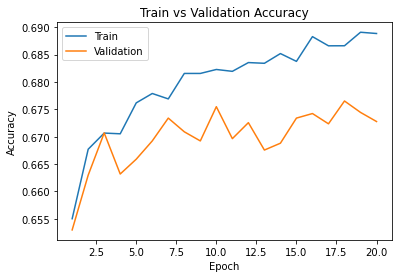

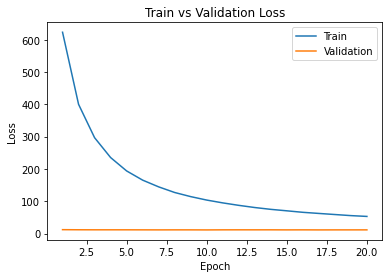

In [16]:
plot_training_curve('third20',20)

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False
alexnet.classifier = nn.Sequential(
                      nn.Linear(256*6*6, 2048), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
                      nn.Linear(256, 101))
alexnet.to(device)
#alexnet = nn.DataParallel(alexnet)

In [ ]:
vgg16 = torchvision.models.vgg.vgg16(pretrained=True)

# for param in vgg16.parameters():
#     param.requires_grad = False
num_features = vgg16.classifier[6].in_features
print(num_features)
vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(num_features, 4096*2), 
                      nn.ReLU(), 
                      nn.Linear(4096*2, 2048), 
                      nn.ReLU(), 
                      nn.Linear(2048, 512), 
                      nn.ReLU(), 
                      nn.Linear(512, 256), 
                      nn.ReLU(), 
                      nn.Linear(256, 101))
vgg16.to(device)

In [3]:
inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False)

for param in inception.parameters():
    param.requires_grad = False

num_ftrs = inception.fc.in_features
inception.fc = nn.Sequential(
                        nn.Dropout(0.7),
                      nn.Linear(num_ftrs, 101))
#                       nn.ReLU(), 
#                       nn.Linear(700, 500), 
#                       nn.ReLU(), 
#                       nn.Linear(500, 300), 
#                       nn.ReLU(), 
#                       nn.Linear(300, 101))

inception.to(device)
skip_ = 1


In [ ]:
r50 = torchvision.models.resnet50(pretrained=True)
num_ftrs = r50.fc.in_features
for param in r50.parameters():
    param.requires_grad = False

# r50.fc =  nn.Sequential(
#               nn.Linear(num_ftrs,1024),
# #                 nn.GlobalAvgPooling(),
# #                 nn.Dense()
#               nn.ReLU(), 
#               nn.Linear(1024, 101))

modules = list(r50.children())[:-1]
r50 = nn.Sequential(*modules)
r50.to(device)
r50.eval()

In [3]:
transform = transforms.Compose([
                                #299
                                # transforms.Resize(310),
                                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                transforms.RandomHorizontalFlip(),
#                                 transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(30, fill=(220,220,220)),
                                transforms.Resize(110),
                                transforms.RandomCrop(100),
                                transforms.ToTensor()])

dataset = ImageFolder(path, transform=transform)
split = DataSplit(dataset,test_train_split=0.9, val_train_split=0.1, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=2048,num_workers=2)

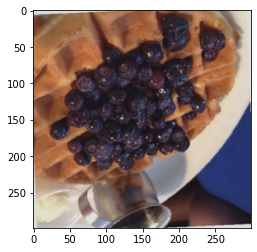

In [4]:
from matplotlib import pyplot as plt
images = next(iter(train_loader))

plt.imshow(np.transpose(images[0][1].numpy(), (1, 2, 0)))

In [14]:
def loaderToFiles(loader, net, path):
    n = 0
    for img, label in loader:
      features = net.features(img.to(device))
      features_tensor = torch.from_numpy(features.to('cpu').detach().numpy())

      folder_name = path + str(classes[label])
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

In [ ]:
loaderToFiles(train_loader, vgg19,'./aimages/')

In [ ]:
loaderToFiles(test_loader, vgg19,'./taimages/')

In [ ]:
loaderToFiles(val_loader, vgg19,'./vaimages/')

In [6]:
def filesToLoader(path,batch_size=4096):
#     transform = transforms.Compose([transforms.ToPILImage(),
# #                                 transforms.Resize(256),
# #                                 transforms.RandomCrop(224),
#                                 transforms.ColorJitter(brightness=0.5),
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.RandomVerticalFlip(),
#                                 transforms.RandomRotation(45),
#                                 transforms.ToTensor()])
    ds = torchvision.datasets.DatasetFolder(path, loader=torch.load, extensions=('.tensor'))
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, 
                                           num_workers=128, shuffle=True)


In [ ]:
train_loader = filesToLoader('./aimages')
val_loader = filesToLoader('./vaimages')
test_loader = filesToLoader('./taimages')

In [4]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.name = "base"
        self.l1 = nn.Linear(3*100*100, 4096)
        self.l2 = nn.Linear(4096, 4096)
        self.l3 = nn.Linear(4096, 512)
        self.l4 = nn.Linear(512, 101)

    def forward(self, x):
        x.to(device)
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [5]:

def train_net(net, optimizer, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # optimizer = optim.RMSprop(net.parameters(), lr=lr)
    # optimizer = optim.RMSprop(net.parameters(), lr=lr)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    i = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_acc = 0.0
        total_epoch = 0
        i += 1
        for inputs, labels in iter(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
#             with torch.no_grad():
#                 inputs = vgg19.features(inputs)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            pred = outputs.data.max(1, keepdim=True)[1]
            curr_correct = pred.eq(labels.data.view_as(pred)).sum()
            total_acc += pred.eq(labels.data.view_as(pred)).sum()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_acc[epoch] = float(total_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {:.4f}, Train loss: {:.6f} | "+
               "Validation acc: {:.4f}, Validation loss: {:.6f}").format(
                   epoch + 1,
                   train_acc[epoch]*100,
                   train_loss[epoch],
                   val_acc[epoch]*100,
                   val_loss[epoch]))

        model_path = get_model_name('baseline', batch_size, learning_rate, epoch)
        if epoch % 10 == 0:
            torch.save(net.state_dict(), model_path+"_net")
            torch.save(optimizer.state_dict(), model_path+"_opt")
            np.savetxt("{}_train_acc.csv".format(epoch), train_acc)
            np.savetxt("{}_train_loss.csv".format(epoch), train_loss)
            np.savetxt("{}_val_acc.csv".format(epoch), val_acc)
            np.savetxt("{}_val_loss.csv".format(epoch), val_loss)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


In [ ]:
net = BaselineModel()
net.to(device)
# net.to(device)
# 0.0001 2 7 12 16 18 19 21
lr = 0.01
# inception.load_state_dict(torch.load('./thirdmodel_vgg_bs512_lr0.0005_epoch20_net'))
optimizer = optim.Adam(net.parameters(), lr=lr)
# optimizer.load_state_dict(torch.load('./thirdmodel_vgg_bs512_lr0.0005_epoch20_opt'))
# optimizer.param_groups[0]['weight_decay'] = 0.00001

# for param_group in optimizer.param_groups:
#     param_group['lr'] = lr

# optim = checkpoint['optimizer']
# net.train()
train_net(net, optimizer, train_loader, val_loader, num_epochs=1000, batch_size=2048, learning_rate=lr)

Epoch 1: Train acc: 1.0292, Train loss: 9325.112262 | Validation acc: 1.0561, Validation loss: 4.616932
Epoch 2: Train acc: 0.9644, Train loss: 61.568720 | Validation acc: 0.8581, Validation loss: 4.616627
Epoch 3: Train acc: 0.9485, Train loss: 46.161030 | Validation acc: 0.9241, Validation loss: 4.616482
Epoch 4: Train acc: 0.9388, Train loss: 36.926633 | Validation acc: 0.8361, Validation loss: 4.616528
Epoch 5: Train acc: 1.0353, Train loss: 30.771620 | Validation acc: 0.8361, Validation loss: 4.616278


In [7]:
evaluate(net, test_loader, nn.CrossEntropyLoss())

(0.5831817000259942, 1.8133326098938618)

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
from PIL import Image

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.to(device)  #assumes that you're using GPU
image = image_loader('/home/unx/Downloads/ms.jpg')
#image = image_loader('/home/unx/Documents/360/pcode/food-101/images/miso_soup/705856.jpg')
net.eval()
net.to(device)
ft =alexnet.features(image)
out = net(ft)
o = torch.max(out, 1)
classes[o.indices.item()]

'miso_soup'

In [ ]:
test_loader_f = []
for i, data in enumerate(test_loader):
  inputs, labels = data
  t = alexnet.features(inputs.to(device))
  t = torch.from_numpy(t.to('cpu').detach().numpy())
  res = (t, labels)
  f = open('./taimages/'+str(i),'wb')
  pickle.dump(res, f)
  f.close()

In [ ]:
def get_acc(loader_):
  total = 0
  total_corr = 0
  for i, data in enumerate(loader_, 0):
    # Get the inputs
    inputs, labels = data
    labels = labels.to(device)
    total+=len(labels)
    outputs = net(inputs.to(device))
    pred = outputs.data.max(1, keepdim=True)[1]
    curr_correct = pred.eq(labels.data.view_as(pred)).sum().item()
    total_corr += curr_correct
  return total_corr/total
for i in range(19):
    f = open('./taimages/'+str(i),'rb')
    t = pickle.load(f)
    test_loader_f.append(t)
get_acc(test_loader_f)